Preprocessing

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn as nn
from torchvision import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class XRayDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, category in enumerate(["Normal", "Pneumonia"]):
            category_dir = os.path.join(image_dir, category)
            for image_name in os.listdir(category_dir):
                self.image_paths.append(os.path.join(category_dir, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx])
        return img, label

train_dataset = XRayDataset(TRAIN_DIR, transform)
test_dataset = XRayDataset(TEST_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Train samples: 1562
Test samples: 624


CNN+DT (Conv2, Conv4, Final)

In [ ]:
cnn_model = models.resnet50(pretrained=True)
cnn_model.eval()

class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        self.base_model = base_model
        self.layer_outputs = {}

        def hook_fn(module, input, output, layer_name):
            self.layer_outputs[layer_name] = output.flatten(start_dim=1)

        base_model.layer2.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, "conv2"))
        base_model.layer4.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, "conv4"))
        base_model.fc.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, "fc"))

    def forward(self, x):
        _ = self.base_model(x)
        return self.layer_outputs["conv2"], self.layer_outputs["conv4"], self.layer_outputs["fc"]

feature_extractor = FeatureExtractor(cnn_model)

def extract_features(data_loader, model):
    model.eval()
    features_list, labels_list = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            conv2_feat, conv4_feat, fc_feat = model(images)
            combined_feat = torch.cat((conv2_feat, conv4_feat, fc_feat), dim=1).cpu().numpy()
            features_list.append(combined_feat)
            labels_list.append(labels.cpu().numpy())

    return np.vstack(features_list), np.hstack(labels_list)

train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, test_labels = extract_features(test_loader, feature_extractor)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.2MB/s]


In [ ]:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(train_features, train_labels)

dt_predictions = dt_model.predict(test_features)

print("Decision Tree Accuracy:", accuracy_score(test_labels, dt_predictions))
print("Classification Report (Decision Tree):\n", classification_report(test_labels, dt_predictions))


Decision Tree Accuracy: 0.7964743589743589
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.87      0.54      0.66       234
           1       0.77      0.95      0.85       390

    accuracy                           0.80       624
   macro avg       0.82      0.74      0.76       624
weighted avg       0.81      0.80      0.78       624



In [ ]:
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(train_features_pca, train_labels)

dt_predictions = dt_model.predict(test_features_pca)

print("PCA Decision Tree Accuracy:", accuracy_score(test_labels, dt_predictions))
print("Classification Report (Decision Tree):\n", classification_report(test_labels, dt_predictions))

PCA Decision Tree Accuracy: 0.7884615384615384
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.80      0.58      0.67       234
           1       0.78      0.91      0.84       390

    accuracy                           0.79       624
   macro avg       0.79      0.75      0.76       624
weighted avg       0.79      0.79      0.78       624



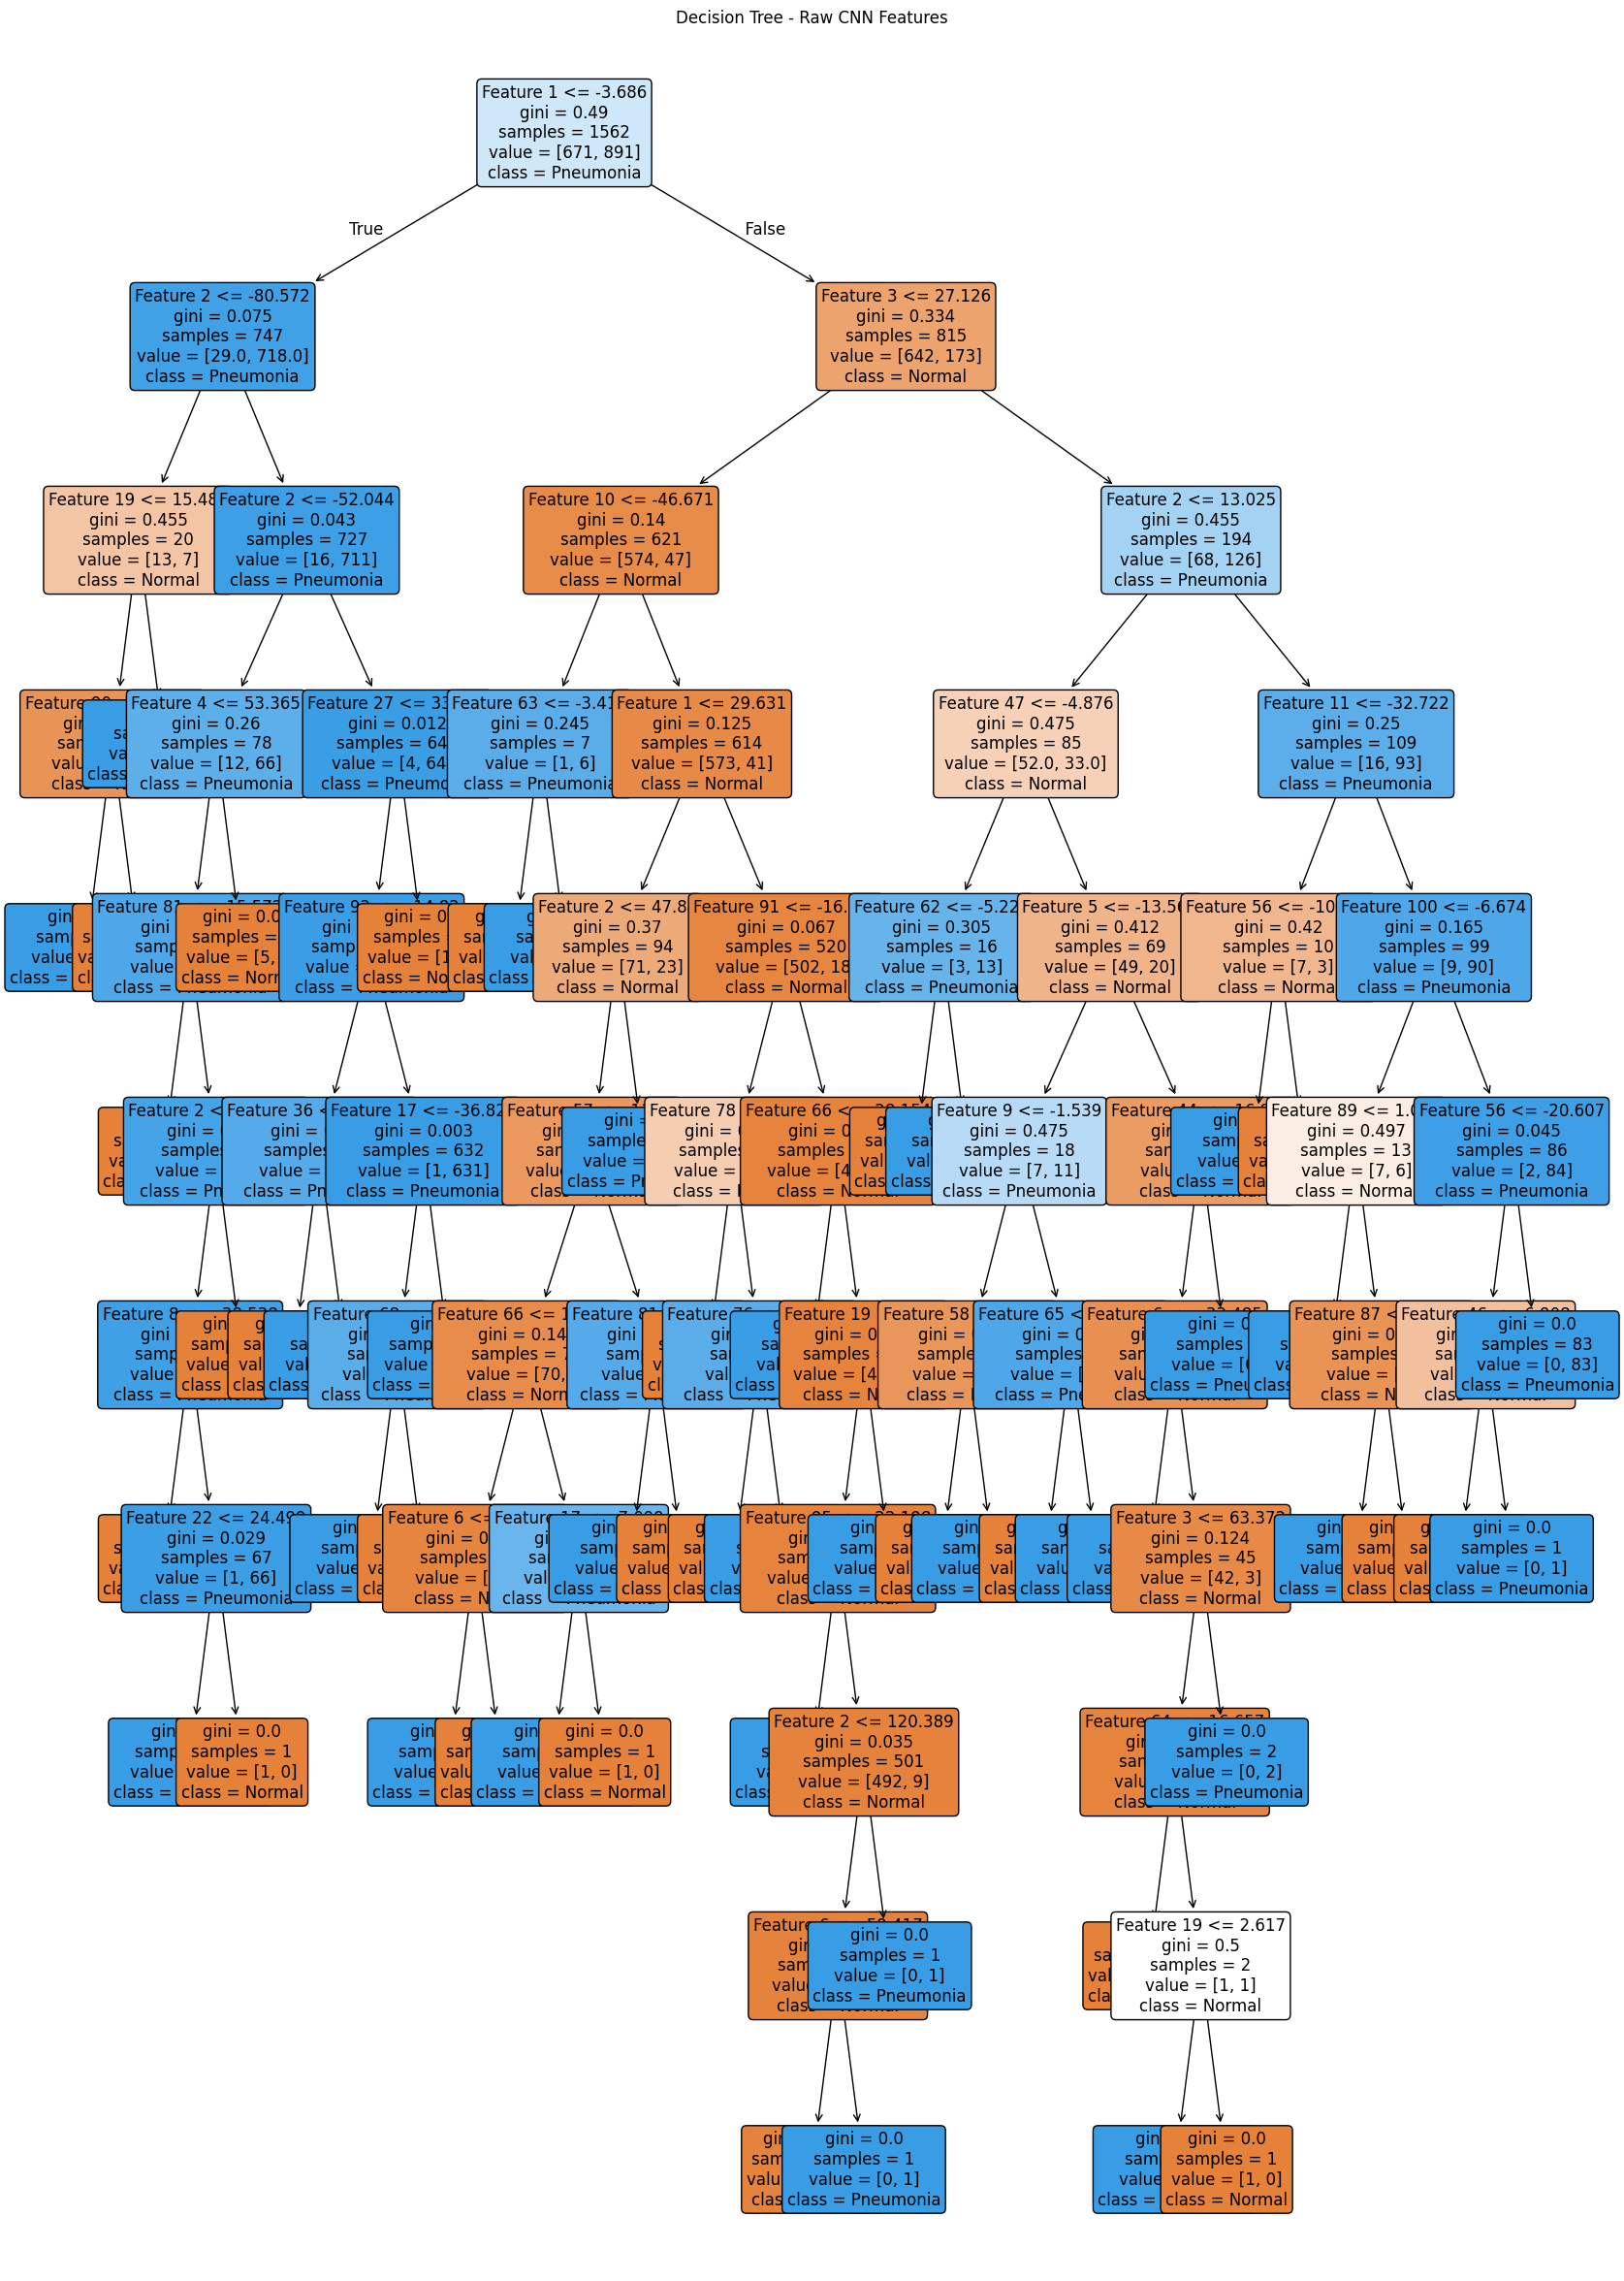

In [ ]:
plt.figure(figsize=(20, 30))
plot_tree(dt_model, filled=True, feature_names=[f"Feature {i+1}" for i in range(train_features.shape[1])], class_names=["Normal", "Pneumonia"], rounded=True, fontsize=12)
plt.title("Decision Tree - Raw CNN Features")
plt.savefig("multi_dt_raw_cnn_features.png", bbox_inches='tight')
plt.show()


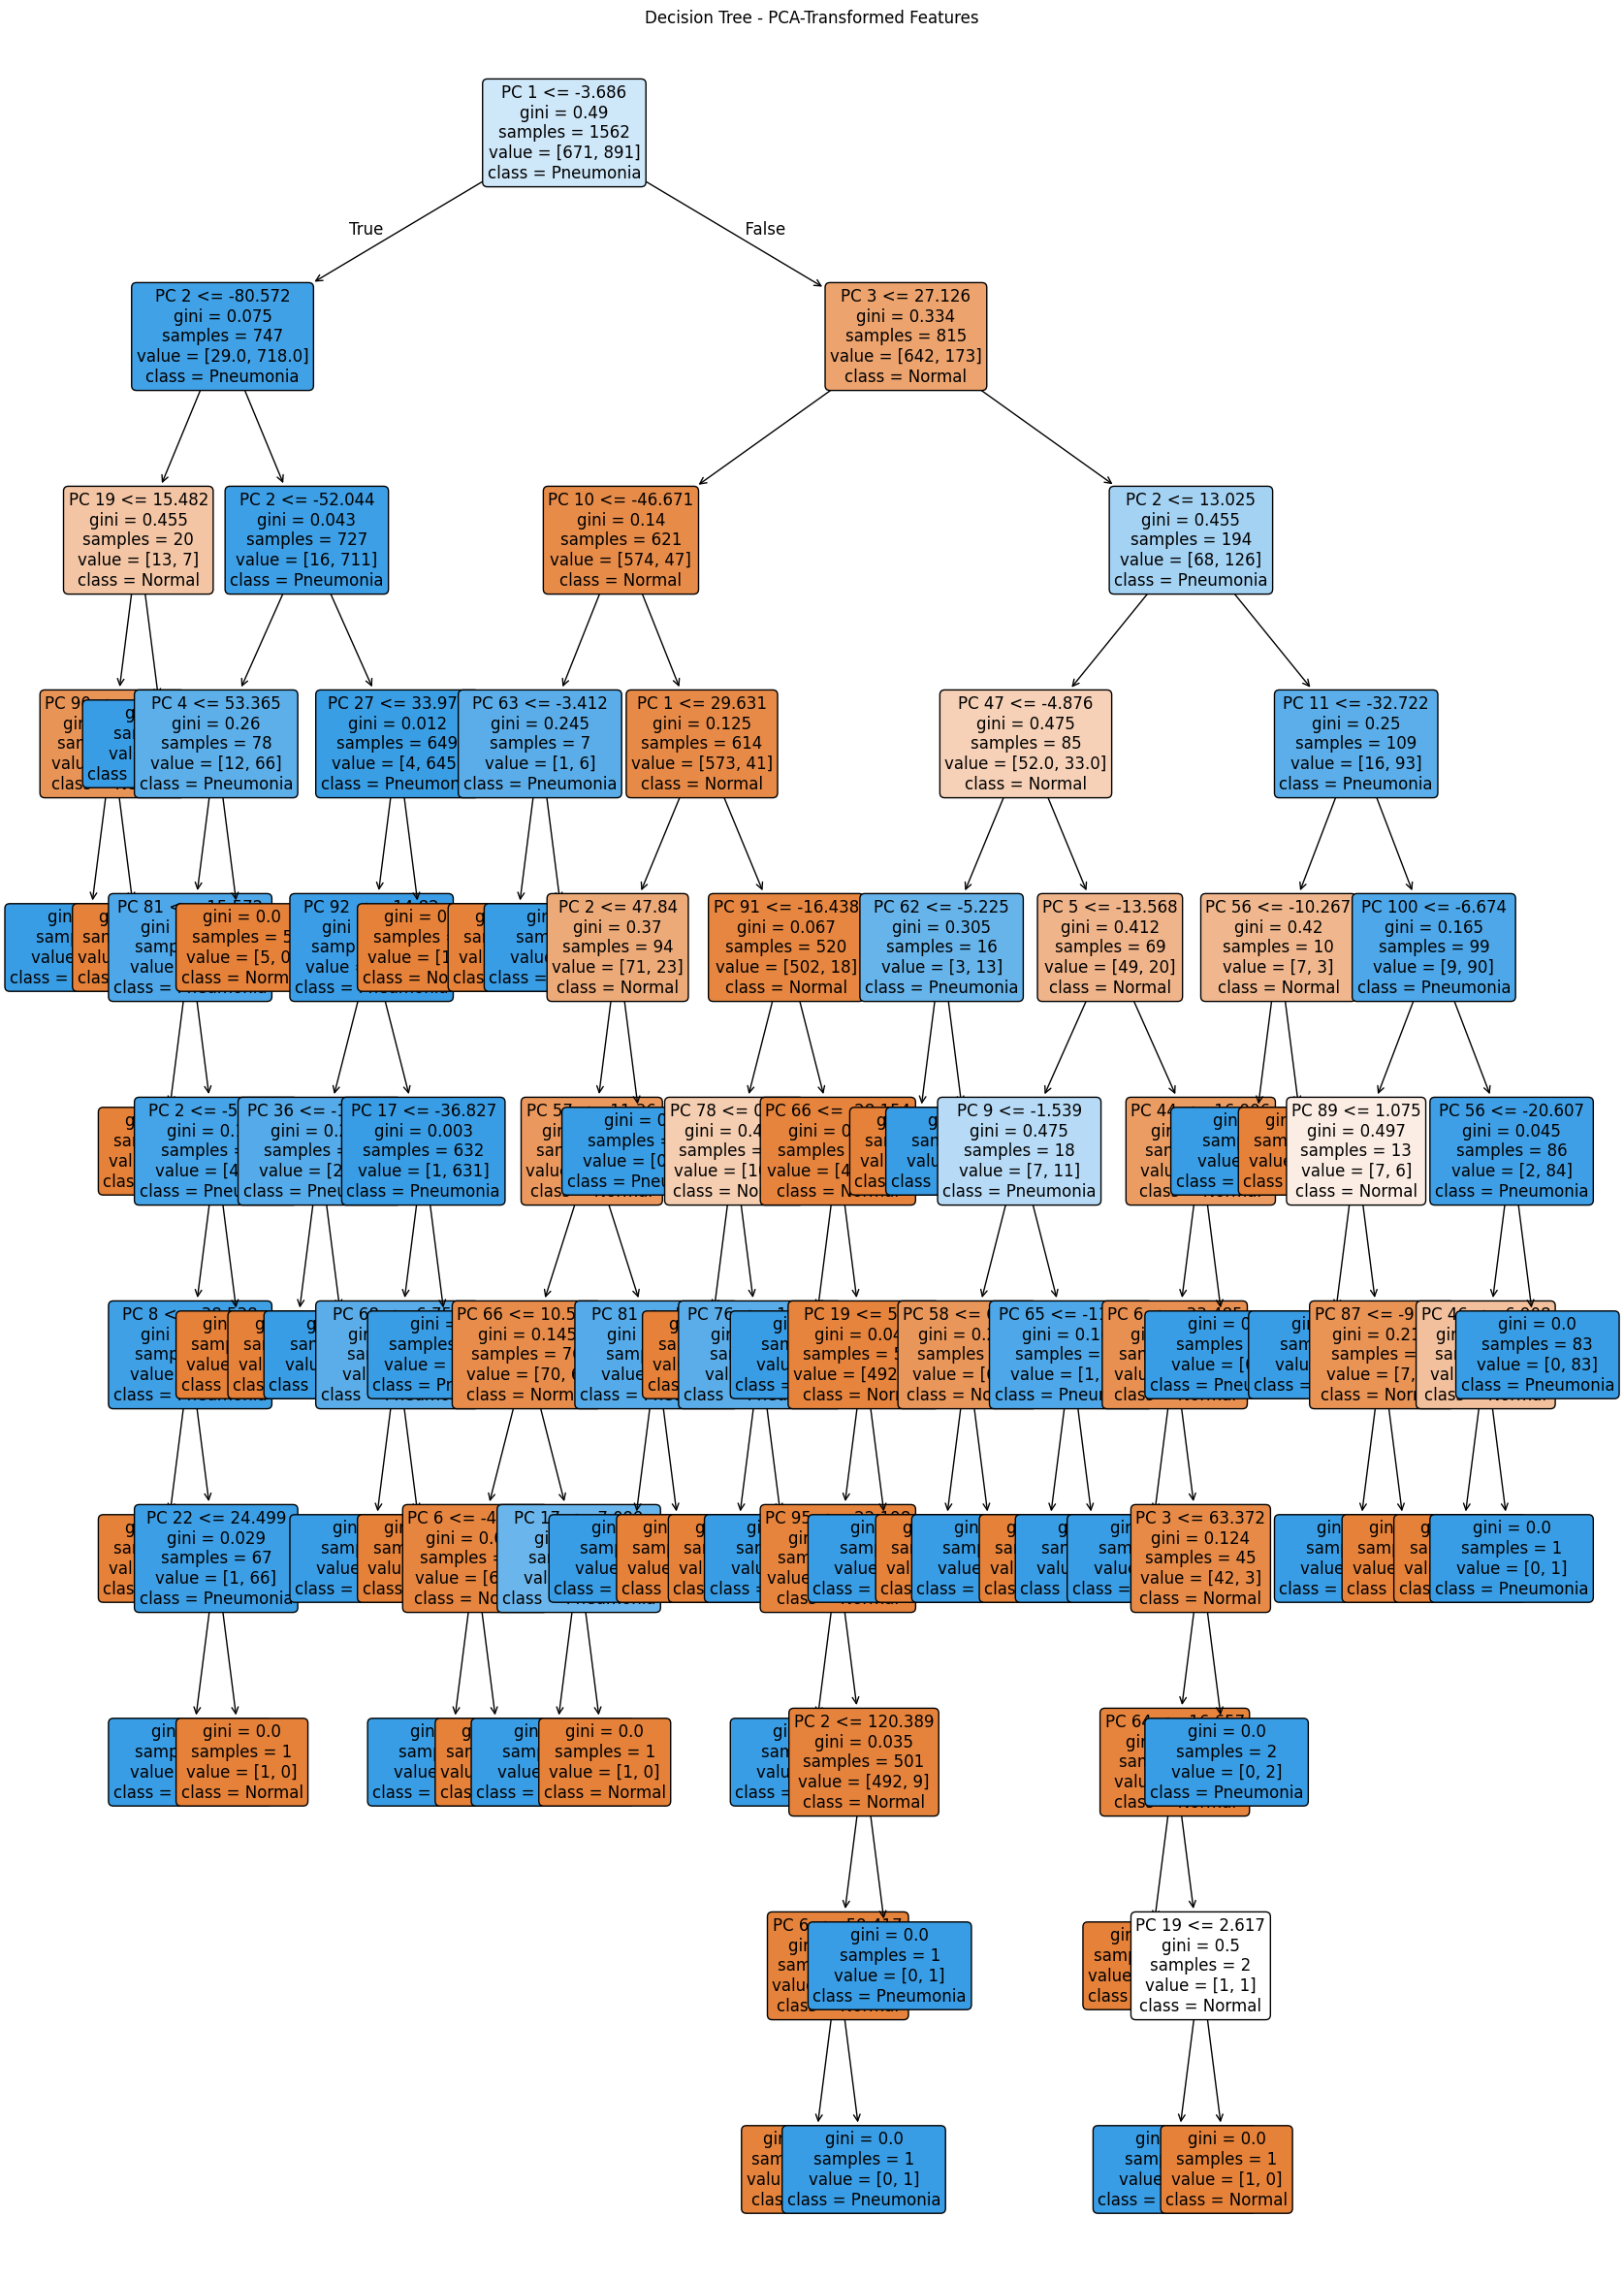

In [ ]:
plt.figure(figsize=(20, 30))
plot_tree(dt_model, filled=True, feature_names=[f"PC {i+1}" for i in range(train_features_pca.shape[1])], class_names=["Normal", "Pneumonia"], rounded=True, fontsize=12)
plt.title("Decision Tree - PCA-Transformed Features")
plt.savefig("multi_dt_pca.png", bbox_inches='tight')
plt.show()

CNN+DT (Only Final)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        self.base_model = base_model
        self.layer_output = None

        def hook_fn(module, input, output):
            self.layer_output = output.flatten(start_dim=1)

        base_model.fc.register_forward_hook(hook_fn)

    def forward(self, x):
        _ = self.base_model(x)
        return self.layer_output

feature_extractor = FeatureExtractor(cnn_model)

def extract_features(data_loader, model):
    model.eval()
    features_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            fc_feat = model(images).cpu().numpy()
            features_list.append(fc_feat)
            labels_list.append(labels.cpu().numpy())
    return np.vstack(features_list), np.hstack(labels_list)

train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, test_labels = extract_features(test_loader, feature_extractor)

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(train_features, train_labels)

dt_predictions = dt_model.predict(test_features)

print("Decision Tree Accuracy:", accuracy_score(test_labels, dt_predictions))
print("Classification Report (Decision Tree):\n", classification_report(test_labels, dt_predictions))

Decision Tree Accuracy: 0.7451923076923077
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.78      0.44      0.57       234
           1       0.74      0.93      0.82       390

    accuracy                           0.75       624
   macro avg       0.76      0.69      0.69       624
weighted avg       0.75      0.75      0.72       624



In [ ]:
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(train_features_pca, train_labels)

dt_predictions = dt_model.predict(test_features_pca)

print("PCA Decision Tree Accuracy:", accuracy_score(test_labels, dt_predictions))
print("Classification Report (Decision Tree):\n", classification_report(test_labels, dt_predictions))

PCA Decision Tree Accuracy: 0.7323717948717948
Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.72      0.47      0.57       234
           1       0.74      0.89      0.81       390

    accuracy                           0.73       624
   macro avg       0.73      0.68      0.69       624
weighted avg       0.73      0.73      0.72       624



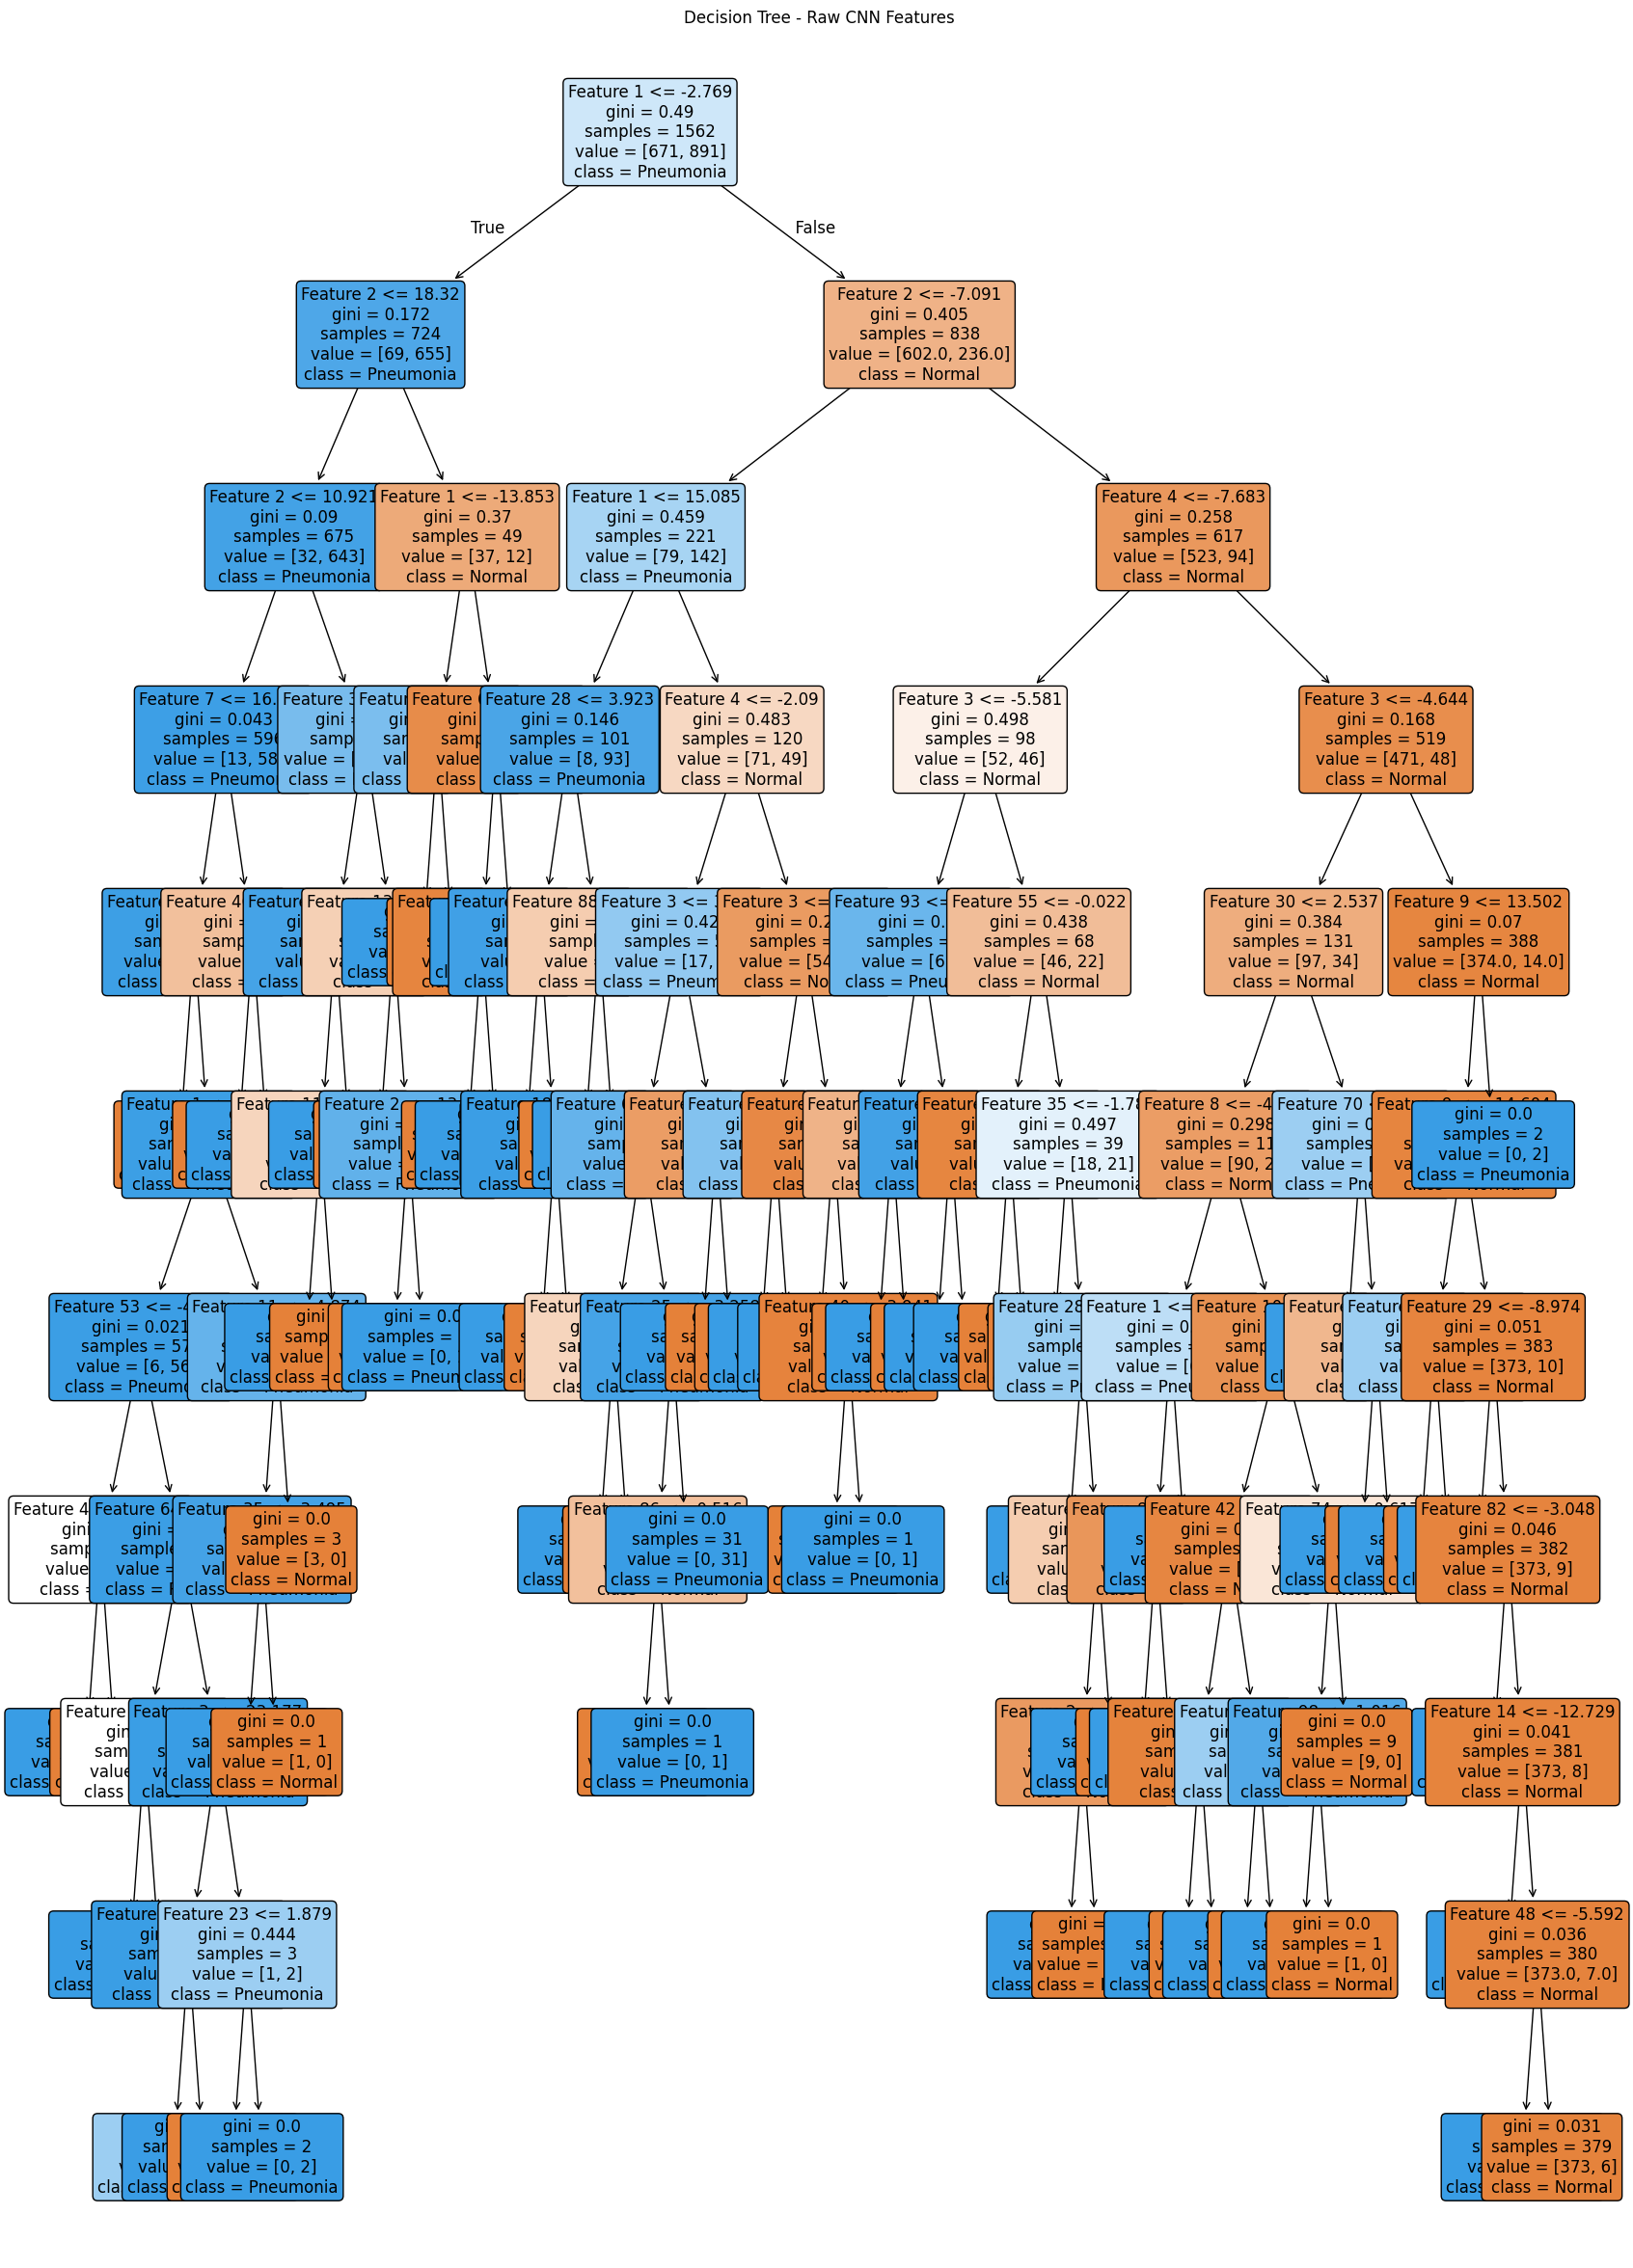

In [ ]:
plt.figure(figsize=(20, 30))
plot_tree(dt_model, filled=True, feature_names=[f"Feature {i+1}" for i in range(train_features.shape[1])], class_names=["Normal", "Pneumonia"], rounded=True, fontsize=12)
plt.title("Decision Tree - Raw CNN Features")
plt.savefig("dt_raw_cnn_features.png", bbox_inches='tight')
plt.show()

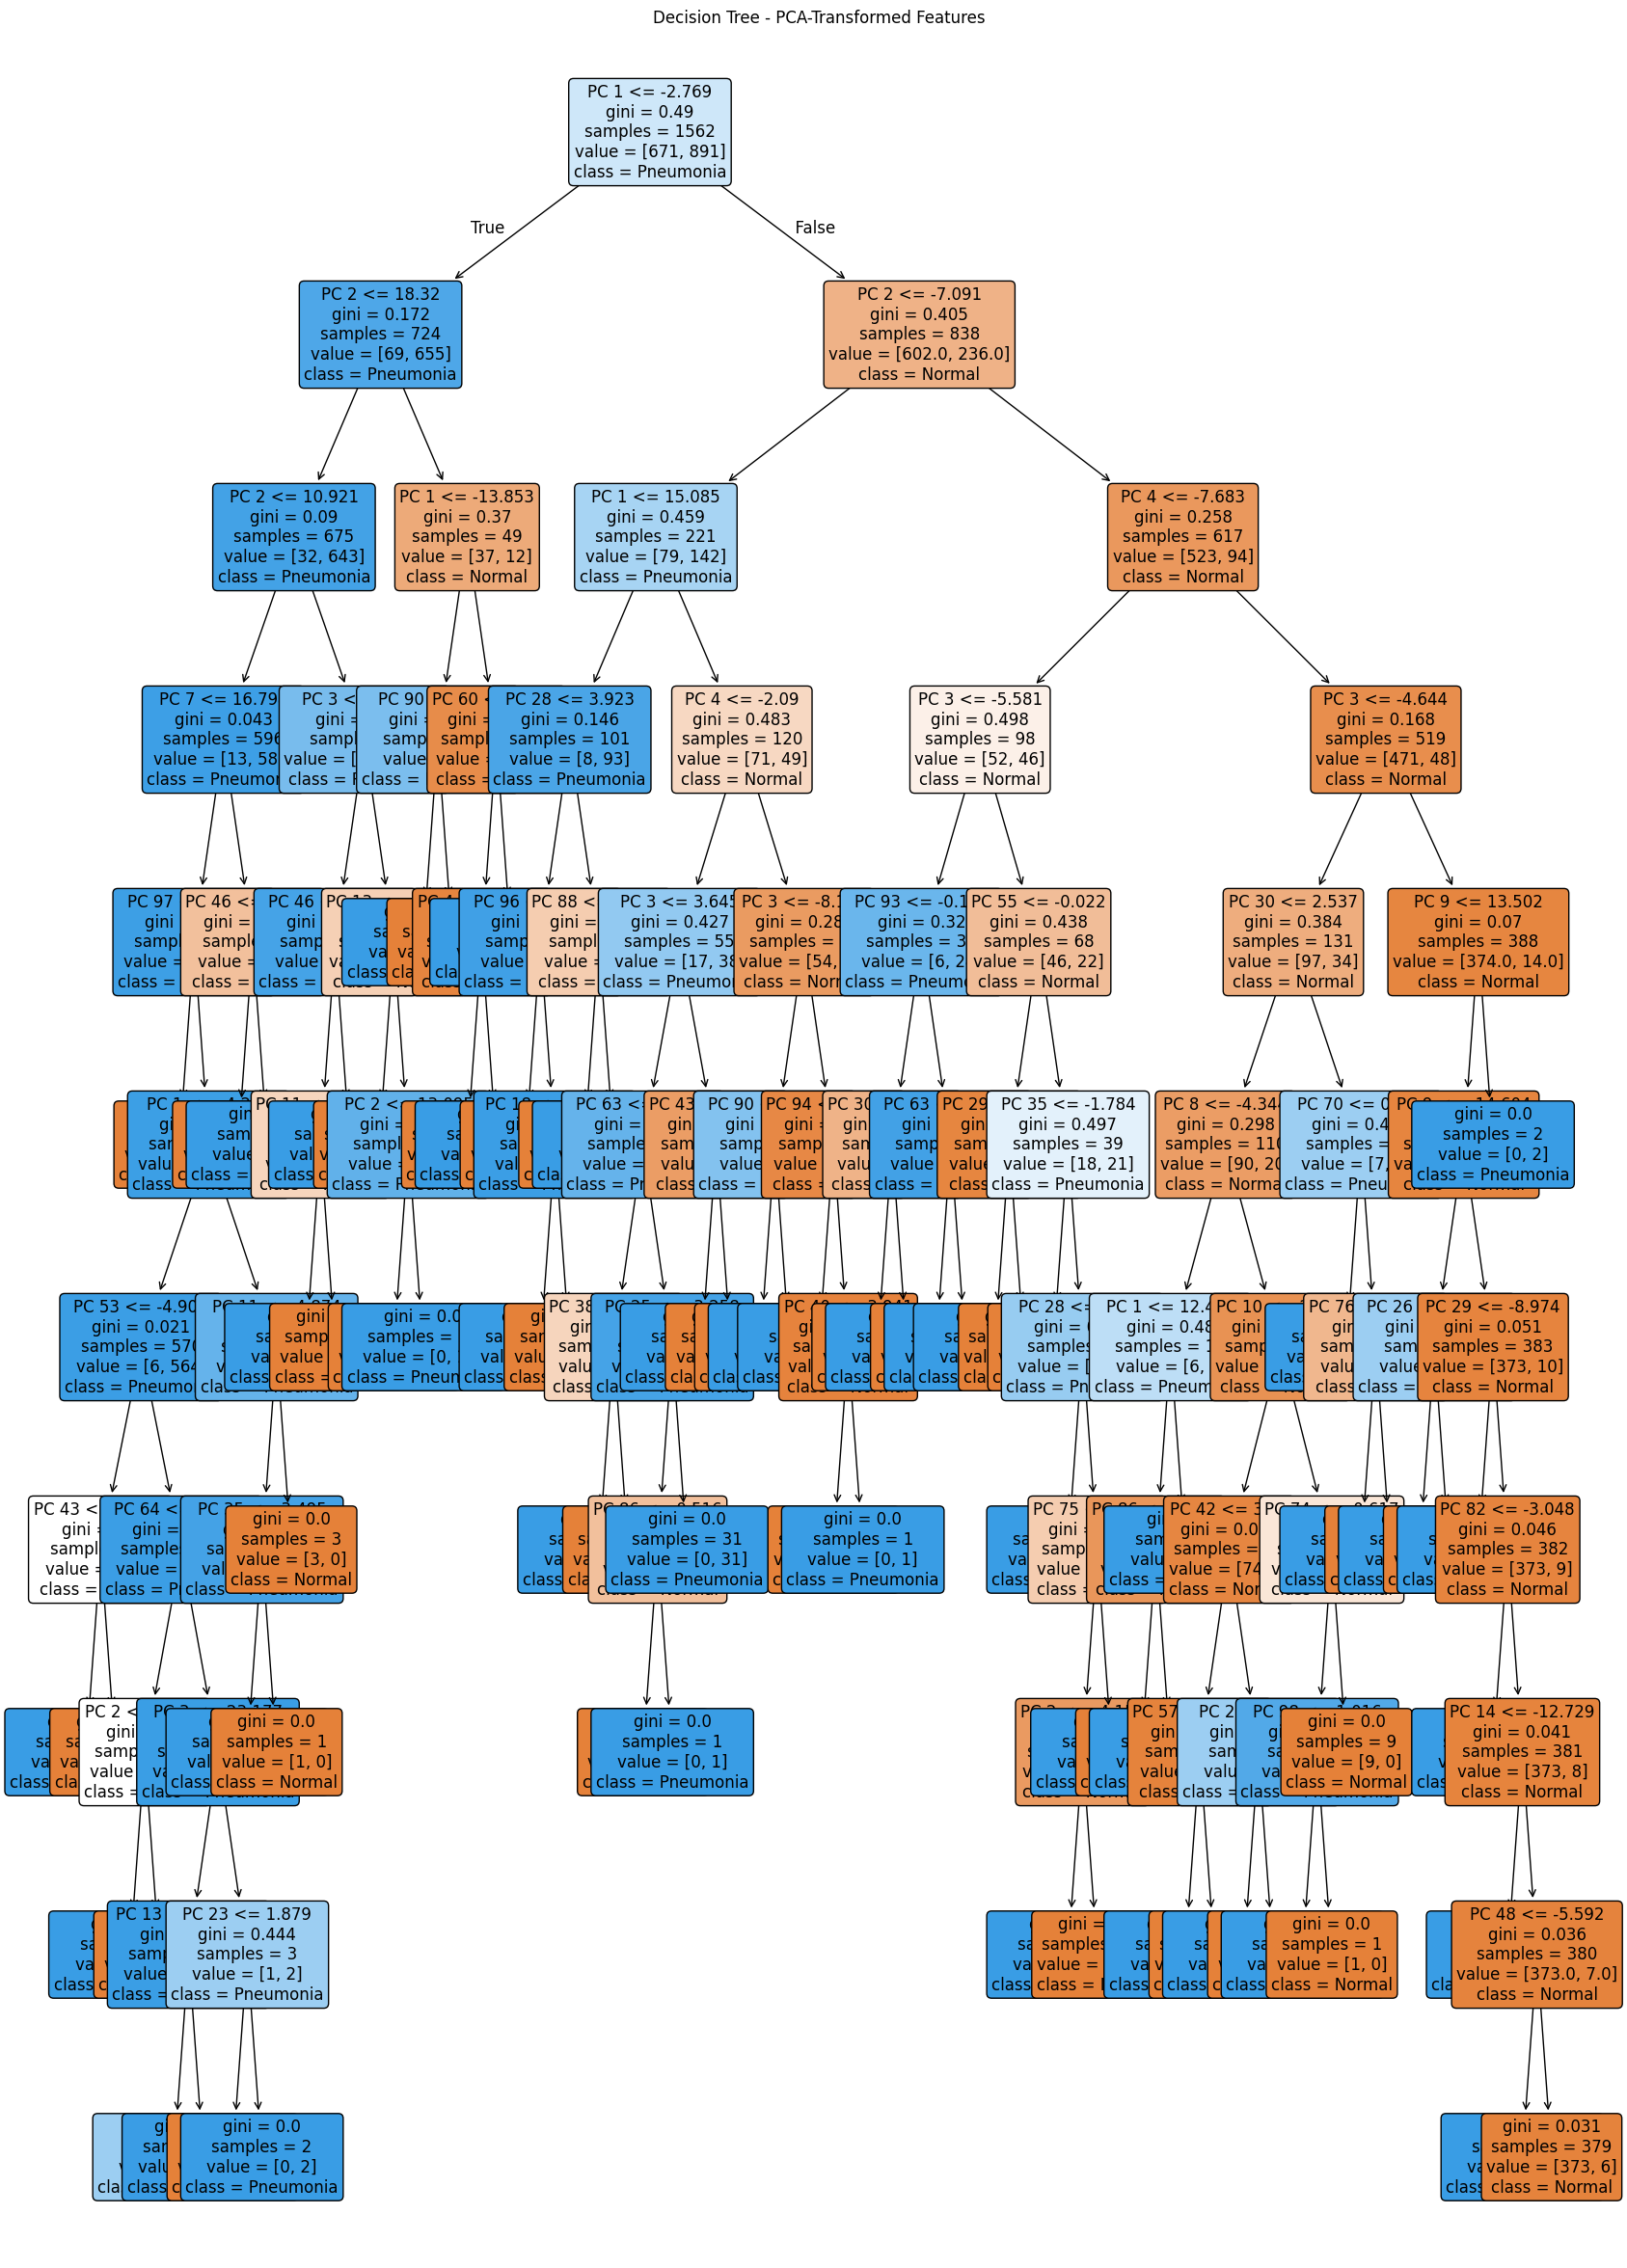

In [ ]:
plt.figure(figsize=(20, 30))
plot_tree(dt_model, filled=True, feature_names=[f"PC {i+1}" for i in range(train_features_pca.shape[1])], class_names=["Normal", "Pneumonia"], rounded=True, fontsize=12)
plt.title("Decision Tree - PCA-Transformed Features")
plt.savefig("dt_pca.png", bbox_inches='tight')
plt.show()

Standalone CNN

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = (outputs > 0.5).float()

        correct += (predictions.view(-1) == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")
report = classification_report(all_labels, all_predictions, target_names=["Normal", "Pneumonia"])
print(report)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.5MB/s]


Epoch [1/5], Loss: 0.5140
Epoch [2/5], Loss: 0.4847
Epoch [3/5], Loss: 0.4801
